# Adding custom PDFs
In this section it will be explained how to create new PDFs and register them within MinKit.
All the different PDFs in this package are built from XML files.
This allows to automatically implement the operations independently of the backend.
The only function that is really needed is that to calculate the value of the probability density function.
Optionally, one can also specify the integral of the PDF between two points.
If so, the normalization and the evaluation on binned data samples are automatically defined, which will boost both processes since no numerical calculations need to be done.

## Basic example
In order to add a new PDF for CPU, we must create a source XML file, and tell the "minkit" package to add its directory to the list of directories to search for PDFs. For this example, we will create a C++ file from python on a temporary directory.

In [1]:
%matplotlib inline
import minkit
import os
import tempfile

tmpdir = tempfile.TemporaryDirectory()

with open(os.path.join(tmpdir.name, 'CustomPDF.xml'), 'wt') as f:
    f.write('''
<PDF>
  <preamble/>
  <parameters k="k"/>
  <function>
    <data x="x"/>
    <code>
      return exp(k * x);
    </code>
  </function>
  <integral>
    <bounds xmin="xmin" xmax="xmax"/>
    <code>
      return 1. / k * (exp(k * xmax) - exp(k * xmin));
    </code>
  </integral>
</PDF>
        ''')

The fields that are present are:

* "preamble" (optional): any kind of definition that needs to be added after the "include" directives.
* "parameters" (optional): defines the parameters that will be used as input arguments for both "function" and "integral". The quoted values will be the actual names of the parameters
* "variable_parameters" (optional): this field controls the possible paramaters of a PDF which might vary in number, like for a polynomial PDF, for example. It must contain both the name of the variable referring to the number of parameters and that for the pointer to their values. More information about this kind of PDFs can be found in the next section.
* "function": refers to the code used to evaluate the PDF. It must contain a field called "data", with the different data parameters to use; and "code", where the actual calculations are done. All the mathematical functions must be available in C.
* "integral" (optional): this field is optional, since not all the PDFs have an analytical expression for the integral. It is recommended to fill this field when possible, since otherwise MinKit relies on numerical calculations to evaluate binned samples and calculate the normalization. THis field must be composed of two parts: "bounds", defining the names for the limits of the integration; and "code", where the calculation of the integral is done. If working with more than one data parameter, "bounds" must contain the lower and upper bounds for each parameter, included consecutively (xmin, xmax, ymin, ymax, ...).

Something very important to remember is that since we are dealing with XML format, the symbols <, >, &, " and ' are protected. We must use the escaped versions. Now we have to register the PDF. In order to be used in python, we must tell minkit to look for PDFs in the temporary directory.

In [2]:
minkit.add_pdf_src(tmpdir.name)

Now we have to build a python object to represent the PDF. This is directly done when inheriting from "minkit.SourcePDF", which will automatically set our PDF.

In [3]:
@minkit.register_pdf
class CustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, k ):
        super(CustomPDF, self).__init__(name, [x], [k])

The "register_pdf" decorator is necessary if we want to save/load the PDF to/from JSON files. It is completely necessary that we call the function the same way we call the source file. The arguments to the "minkit.SourcePDF" constructor are the name of the PDF, the data parameters and the argument parameters. Now we can declare and use our function.

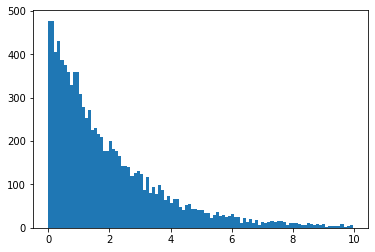

In [4]:
x = minkit.Parameter('x', bounds=(0, 10))
k = minkit.Parameter('k', -0.5)
pdf = CustomPDF('pdf', x, k)
data = pdf.generate(10000)
import matplotlib.pyplot as plt
plt.hist(data['x'].as_ndarray(), bins=100);

## New PDFs with a variable number of arguments
It might happen that one wants to define a general function, which depends on a list of parameters that can vary (for example, a polynomial) from one construction to another.
This can be done on a similar way to that of the previous section, providing as a third argument to "minkit.SourcePDF" the list of extra arguments.

In [5]:
@minkit.register_pdf
class VarArgsCustomPDF(minkit.SourcePDF):
    def __init__( self, name, x, *coeffs ):
        super(VarArgsCustomPDF, self).__init__(name, [x], None, coeffs)

The XML file must be modified accordingly, using the field "variable_parameters":

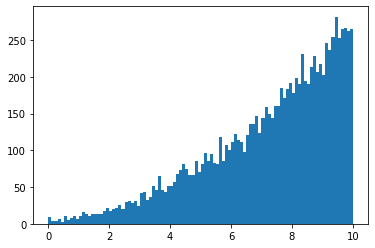

In [6]:
with open(os.path.join(tmpdir.name, 'VarArgsCustomPDF.xml'), 'wt') as f:
    f.write('''
<PDF>
  <preamble/>
  <variable_parameters n="n" p="p"/>
  <function>
    <data x="x"/>
    <code>
      if ( n == 0 )
        return 1.;
        
      double out = x * p[n - 1];
      for ( int i = 0; i &lt; n; ++i )
        out = x * (out + p[n - i - 1]);
      return out + 1.;
    </code>
  </function>
</PDF>
        ''')
    
x = minkit.Parameter('x', bounds=(0, 10))
p1 = minkit.Parameter('p1', +0.5)
pdf = VarArgsCustomPDF('pdf', x, p1)
data = pdf.generate(10000)
import matplotlib.pyplot as plt
plt.hist(data['x'].as_ndarray(), bins=100);